In [1]:
!chcp 65001

import random
import os
import pathlib
import splitfolders
import shutil
from pydub import AudioSegment
from pydub.utils import mediainfo

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' 

Active code page: 65001


# Параметры

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
EARLY_STOP = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
CHECKPOINT = lambda MODEL_NAME: tf.keras.callbacks.ModelCheckpoint(cpt_path(MODEL_NAME), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

EPOCHS = 10

# Работа с файлами

In [7]:
wav_data = pathlib.Path('wav_data')

# pathlib.Path.mkdir(wav_data / 'male')
# pathlib.Path.mkdir(wav_data / 'female')

with open('female.txt', 'r') as file:
    content =  file.read()
    fem_list = content.split('\n')
with open('male.txt', 'r') as file:
    content =  file.read()
    male_list = content.split('\n')

for file in male_list:
    try:
        shutil.copy(wav_data / file, wav_data / 'male' / file)
    except:
        pass

for file in fem_list:
    try:
        shutil.copy(wav_data / file, wav_data / 'female' / file)
    except:
        pass

# Функции

In [8]:
def count_dataset_samples(DATASET_PATH):
    data_dir = pathlib.Path(DATASET_PATH)
    classes = np.array(tf.io.gfile.listdir(str(data_dir)))
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    print('Number of examples of human class:',
          len(tf.io.gfile.listdir(str(data_dir/classes[0]))))
    print('Number of examples of spoof class:',
          len(tf.io.gfile.listdir(str(data_dir/classes[1]))))
    print('Example file tensor:', filenames[0])
    return classes


def split_dataset(DATASET_PATH, SPLIT_PATH, RATIO=(.8, .1, .1)):
    data_dir = pathlib.Path(DATASET_PATH)
    split_dir = pathlib.Path(SPLIT_PATH)
    pathlib.Path.mkdir(split_dir, exist_ok=True)
    splitfolders.ratio(data_dir, output=split_dir,
                      seed=0, ratio=RATIO, group_prefix=None)

    train_dir = split_dir / 'train'
    val_dir = split_dir / 'val'
    test_dir = split_dir / 'test'

    train_files = tf.random.shuffle(tf.io.gfile.glob(str(train_dir) + '/*/*'))
    val_files = tf.random.shuffle(tf.io.gfile.glob(str(val_dir) + '/*/*'))
    test_files = tf.random.shuffle(tf.io.gfile.glob(str(test_dir) + '/*/*'))

    print('Training set size', len(train_files))
    print('Validation set size', len(val_files))
    print('Test set size', len(test_files))
    
    return train_files, val_files, test_files

# Функция для декодирования wav файла
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

# Функция для создания метки аудиофайла
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

# Объединение двух предыдущих
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

# Получение спектограммы
def get_spectrogram(waveform, windows_size=255, hop_len=128):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
      equal_length, frame_length=windows_size, frame_step=hop_len)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

# Получение спектограммы и лейбла
def get_spectrogram_and_label_id(audio, label, windows_size=255, hop_len=128):
    spectrogram = get_spectrogram(audio, windows_size=windows_size, hop_len=hop_len)
    label_id = tf.argmax(label == CLASSES)
    return spectrogram, label_id

# Препроцессинг
def preprocess_dataset(files, windows_size=255, hop_len=128):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
    return output_ds

def preprocessing(train_files, val_files, test_files, AUTOTUNE=AUTOTUNE, BATCH_SIZE=BATCH_SIZE):
    train_ds = preprocess_dataset(train_files)
    val_ds = preprocess_dataset(val_files)
    test_ds = preprocess_dataset(test_files)
    
    train_ds = train_ds.batch(BATCH_SIZE)
    val_ds = val_ds.batch(BATCH_SIZE)

    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    return train_ds, val_ds, test_ds

def get_norm_layer(DS):
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=DS.map(map_func=lambda spec, label: spec))
    return norm_layer

from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score

def test_metrics(MODEL, TEST_DS):
    test_audio, test_labels = [], []

    for audio, label in TEST_DS:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())

    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)

    y_pred = np.argmax(MODEL.predict(test_audio), axis=1)
    y_true = test_labels

    test_acc = sum(y_pred == y_true) / len(y_true)
    test_f1 = f1_score(y_true, y_pred)
    test_roc_auc = roc_auc_score(y_true, y_pred)
    test_recall = recall_score(y_true, y_pred)
    test_precision = precision_score(y_true, y_pred)
    return (test_acc, test_f1, test_roc_auc, test_recall, test_precision)

class TrippleChannels(tf.keras.Model):
    def __init__(self):
        super(TrippleChannels, self).__init__()
    def call(self, inp):
        out = tf.repeat(inp, repeats=[3], axis=-1)
        return out

def cpt_path(MODEL_NAME):
    path = pathlib.Path(f"models/{MODEL_NAME}/")
    path.mkdir(exist_ok=True, parents=True) # создаем папку на диске
    cpt_filename = "{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5"  
    cpt_path = str(path / cpt_filename)
    return cpt_path

def file_info(file_path):
    sound = AudioSegment.from_wav(file_path)
    freq = sound.frame_rate
    chan = sound.channels
    bitr = mediainfo(file_path)['bit_rate']
    print(f'File info:\nBitrate: {bitr[:3]} kbps\nChannels: {chan}\nFrequency: {freq} Hz')

## Подготовка данных

In [9]:
DATASET_PATH = 'wav_data'

In [11]:
CLASSES = count_dataset_samples(DATASET_PATH)
NUM_LABELS = len(CLASSES)

Number of total examples: 204
Number of examples of human class: 102
Number of examples of spoof class: 102
Example file tensor: tf.Tensor(b'wav_data\\male\\A30001M2.wav', shape=(), dtype=string)


Рездалим датасет на тренировочную, валидационную и тестовую части:

In [12]:
SPLIT_PATH = 'split'
shutil.rmtree(SPLIT_PATH, ignore_errors=True)
train_files, val_files, test_files = split_dataset(DATASET_PATH, SPLIT_PATH)

Copying files: 204 files [00:01, 186.48 files/s]

Training set size 162
Validation set size 20
Test set size 22


## Обычная CNN

In [13]:
MODEL_NAME = "Simple_CNN"

In [14]:
train_ds, val_ds, test_ds = preprocessing(train_files, val_files, test_files)
norm_layer = get_norm_layer(train_ds)

In [26]:
for spectrogram, _ in train_ds.take(1):
    INPUT_SHAPE = spectrogram.shape[1:]

model = models.Sequential([
    layers.Input(shape=(124, 129, 1)),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_LABELS),
])

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

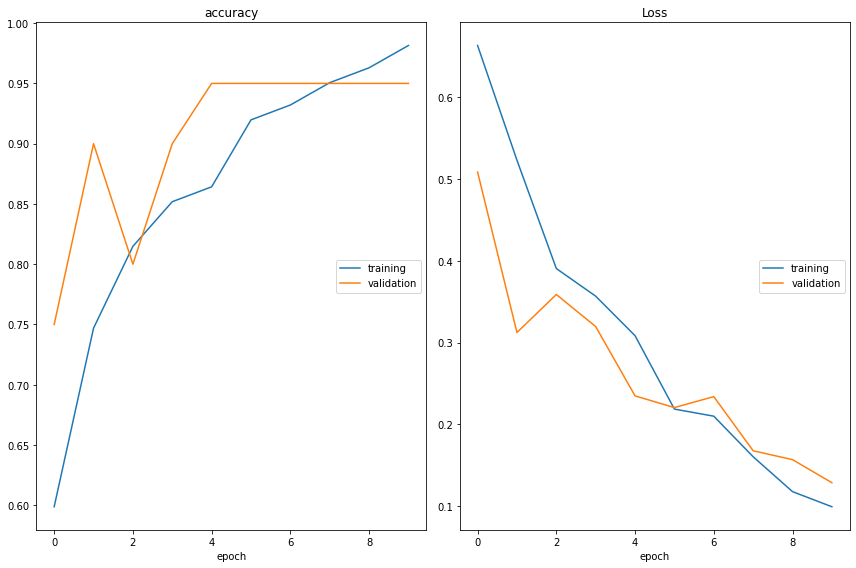

accuracy
	training         	 (min:    0.599, max:    0.981, cur:    0.981)
	validation       	 (min:    0.750, max:    0.950, cur:    0.950)
Loss
	training         	 (min:    0.099, max:    0.664, cur:    0.099)
	validation       	 (min:    0.128, max:    0.509, cur:    0.128)


In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=PlotLossesCallback(),
    verbose=0
)

## Основные метрики классификации

In [29]:
test_acc, test_f1, test_roc_auc, test_recall, test_precision = test_metrics(model, test_ds)
print(f'Test set accuracy: {test_acc:.0%}')
print(f'Test set F1 score: {test_f1:.0%}')
print(f'Test set ROCAUC: {test_roc_auc:.0%}')
print(f'Test set Recall: {test_recall:.0%}')
print(f'Test set Precision: {test_precision:.0%}')

Test set accuracy: 95%
Test set F1 score: 96%
Test set ROCAUC: 95%
Test set Recall: 100%
Test set Precision: 92%


## Сохранение и инференс модели

In [30]:
model.save('test_model.h5')

In [31]:
SAMPLE_PATH = 'sample.wav'

In [32]:
new_model = tf.keras.models.load_model('test_model.h5')

In [33]:
def inference(SAMPLE_PATH):
    with open(SAMPLE_PATH, 'br') as wav:
        wav_binary = wav.read()

    wav_decoded = decode_audio(wav_binary)

    spectrogram = get_spectrogram(wav_decoded, windows_size=255, hop_len=128)

    y_pred = np.argmax(new_model.predict(spectrogram[None, ...]), axis=1)
    if y_pred[0] == 1:
        predicted_gender = 'male'
    else:
        predicted_gender = 'female'
    return predicted_gender

In [34]:
inference(SAMPLE_PATH)

'male'